# 3.2-Clustering and further filtering

**Inés Sentís**

Date of execution 

In [1]:
Sys.Date()

[1] "2025-01-09"

## Introduction

Remove further cells and re-do normalization embeddings and clustering

In [2]:
timepoint <- "T3"

## Libraries

In [3]:
suppressMessages(suppressWarnings({
library(Seurat)
library(here)
library(glue)
library(tidyverse)
library(grid)
library(gridExtra)
library(ggplot2)
library(harmony)
library(scater) 
library(scran)
}))

## Parameters

In [4]:
#dr_here(show_reason = TRUE)
source(here("SCGRES_83_84/sc_analysis/misc/paths.R"))
source(here("utils/bin.R"))

set.seed(0)

## Load data

In [5]:
seurat_obj <- readRDS(here(glue("{clust}/{robj_dir}/dimred_combined_object_{timepoint}.rds")))

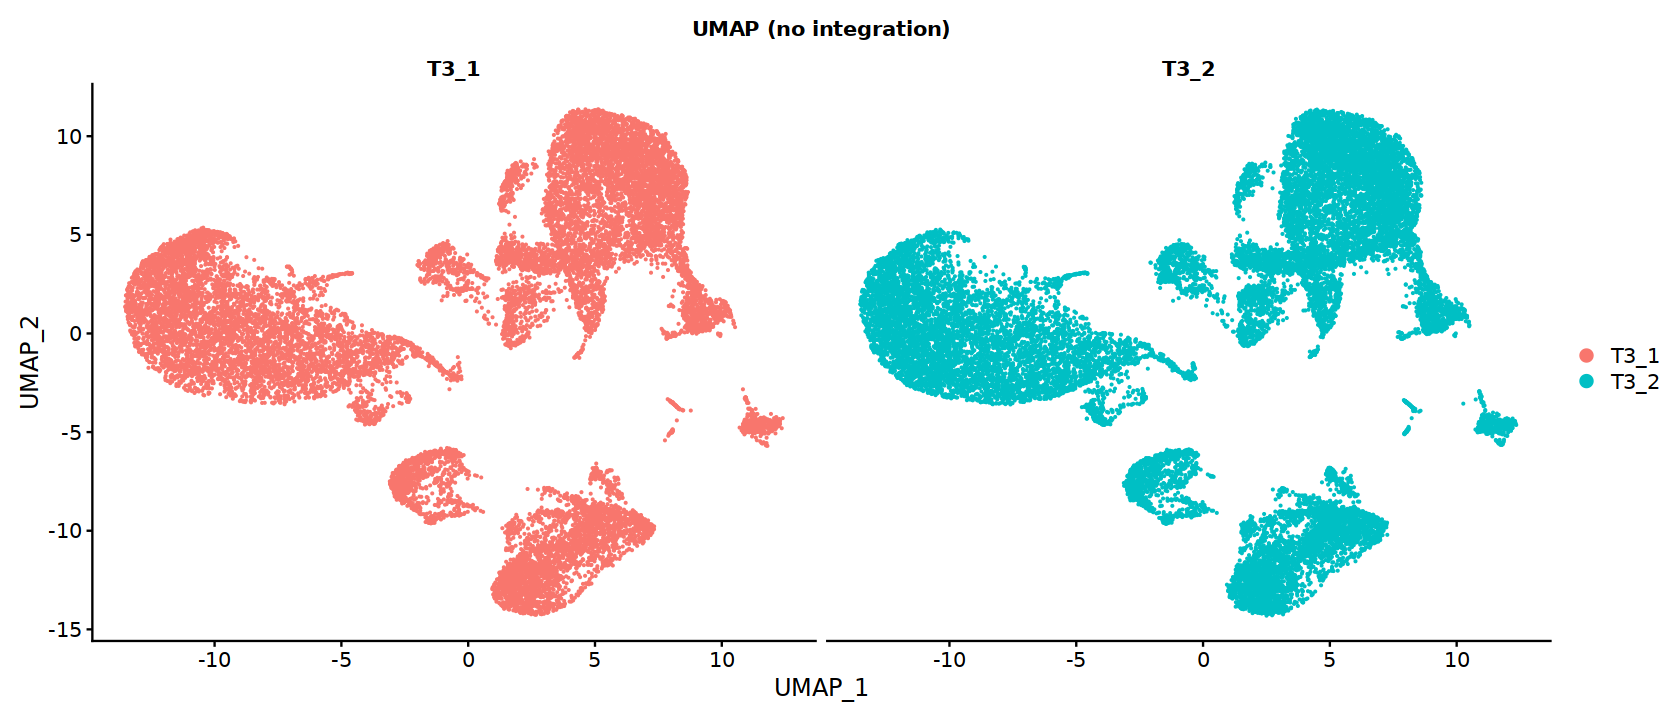

In [6]:
options(repr.plot.width = 14, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  split.by = "sample_id",
  pt.size = 0.1
) + ggtitle('UMAP (no integration)') + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

## Remove potential erythrocytes

In [7]:
seurat_obj <- subset(x = seurat_obj, 
                     subset = HBM == 0 & HEMGN == 0 & HBG2 == 0)

In [8]:
seurat_obj <- DietSeurat(
  seurat_obj,
  counts = TRUE,
  data = TRUE,
  scale.data = FALSE,
  features = NULL,
  assays = NULL,
  dimreducs = FALSE,
  graphs = NULL
)

In [9]:
print(table(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) == 0))
  
keep_genes <- data.frame(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) != 0)
colnames(keep_genes) <- "logical"
keep_genes <- subset(keep_genes, logical==TRUE)
seurat_obj[['RNA']]@counts <- seurat_obj[['RNA']]@counts[rownames(keep_genes), ]
seurat_obj[['RNA']]@data <- seurat_obj[['RNA']]@data[rownames(keep_genes), ]
seurat_obj


FALSE  TRUE 
27369  1748 


An object of class Seurat 
27369 features across 15824 samples within 1 assay 
Active assay: RNA (27369 features, 0 variable features)

### Re-do embedding

In [10]:
seurat_obj <- NormalizeData(
  seurat_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)

In [11]:
sce <- as.SingleCellExperiment(seurat_obj)
sce

class: SingleCellExperiment 
dim: 27369 15824 
metadata(0):
assays(2): counts logcounts
rownames(27369): AL627309.1 AL627309.3 ... UTY TMSB4Y
rowData names(0):
colnames(15824): T3_1_AAACCTGAGACCTTTG-1 T3_1_AAACCTGAGAGGTACC-1 ...
  T3_2_TTTGTCATCCTGCCAT-1 T3_2_TTTGTCATCTTAGCCC-1
colData names(16): orig.ident nCount_RNA ... old.ident ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

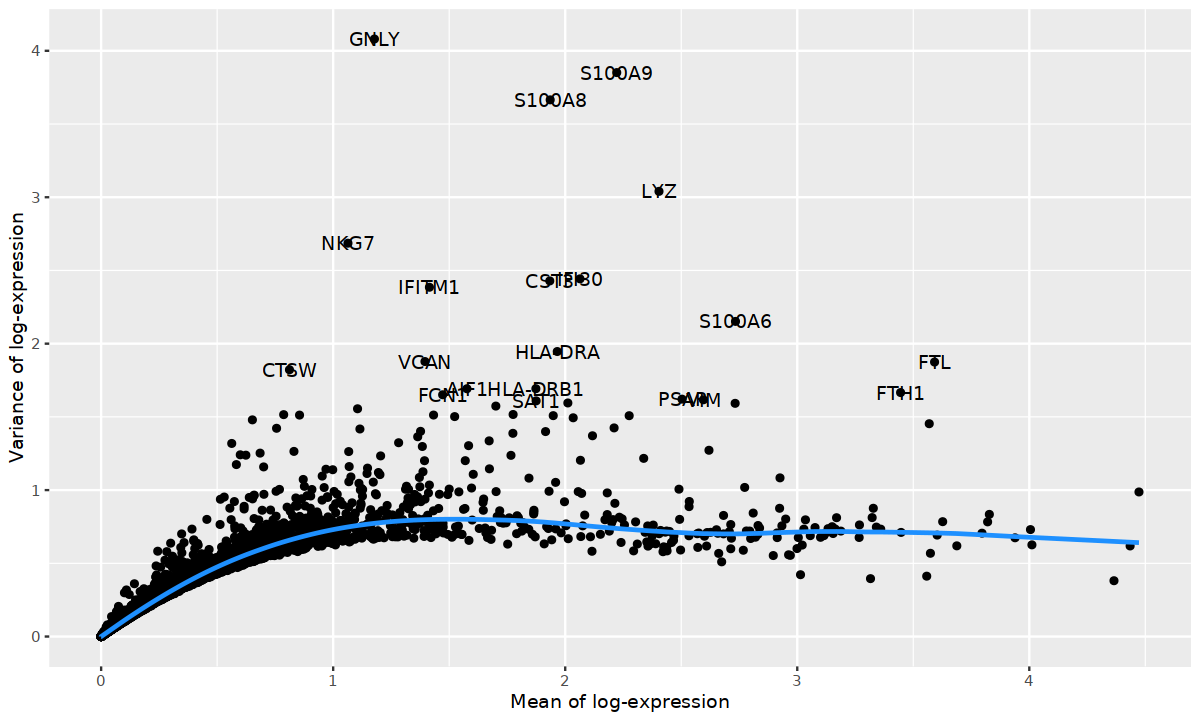

In [12]:
options(repr.plot.width = 10, repr.plot.height = 6, warn=-1,verbose = FALSE)
gene_var <- modelGeneVar(sce)

tops <- gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)

gene_var %>% 
  as.data.frame() %>% 
  ggplot(aes(mean, total)) +
  geom_point() +
  geom_line(aes(y = tech), colour = "dodgerblue", size = 1) +
  labs(x = "Mean of log-expression", y = "Variance of log-expression")+
  geom_text(data=tops, aes(mean,total,label=rownames(tops)))

In [13]:
hvgs <- getTopHVGs(gene_var,fdr.threshold = 0.05)
length(hvgs)

[1] 1359

In [14]:
# remove TCR genes
hvgs <- hvgs[!grepl("^TR[ABDG][VJC]", hvgs)]

In [15]:
seurat_obj <- seurat_obj %>%
  ScaleData(features=hvgs) %>% 
  RunPCA(features=hvgs)

Centering and scaling data matrix

PC_ 1 
Positive:  IFI30, LYZ, AIF1, FCN1, S100A6, FTL, S100A9, LST1, CTSS, PSAP 
	   NAMPT, SPI1, CST3, S100A11, CYBB, CDKN1A, PLXDC2, HLA-DRA, S100A8, SERPINA1 
	   HLA-DRB1, VCAN, CD68, VIM, MNDA, SAT1, RBM47, FTH1, GABARAP, MAFB 
Negative:  CD7, CD247, CTSW, NKG7, GNLY, IFITM1, IL2RB, SKAP1, IL2RG, PRF1 
	   GZMA, CST7, SLC38A1, PRKCH, ZAP70, CD69, CD96, KLRB1, KLRK1, KLRD1 
	   IL32, TENT5C, RNF125, SAMD3, GZMM, SYNE1, ETS1, MCTP2, GZMB, EVL 
PC_ 2 
Positive:  JCHAIN, LILRA4, SERPINF1, CLEC4C, NIBAN3, RHEX, IGKC, ITM2C, DERL3, MZB1 
	   PTPRS, LINC01374, SPIB, LINC01478, TCF4, COBLL1, CUX2, AC023590.1, DNASE1L3, TLR9 
	   SMPD3, RGS7, PLD4, LINC00996, AC007381.1, TPM2, IGHM, COL24A1, MAP1A, PHEX 
Negative:  IFITM3, NEAT1, ANXA1, S100A10, NFKBIA, ARHGAP26, IFITM2, CCL5, S100A4, JUNB 
	   NKG7, GNLY, IFITM1, PRF1, SLC2A3, TSPO, NR4A2, GZMA, S100A9, CST7 
	   S100A8, FCN1, IL2RB, ATP2B1, CTSW, KLRD1, LYZ, CD247, IFI30, KLRK1 
PC_ 3 
Positive:  TYROBP

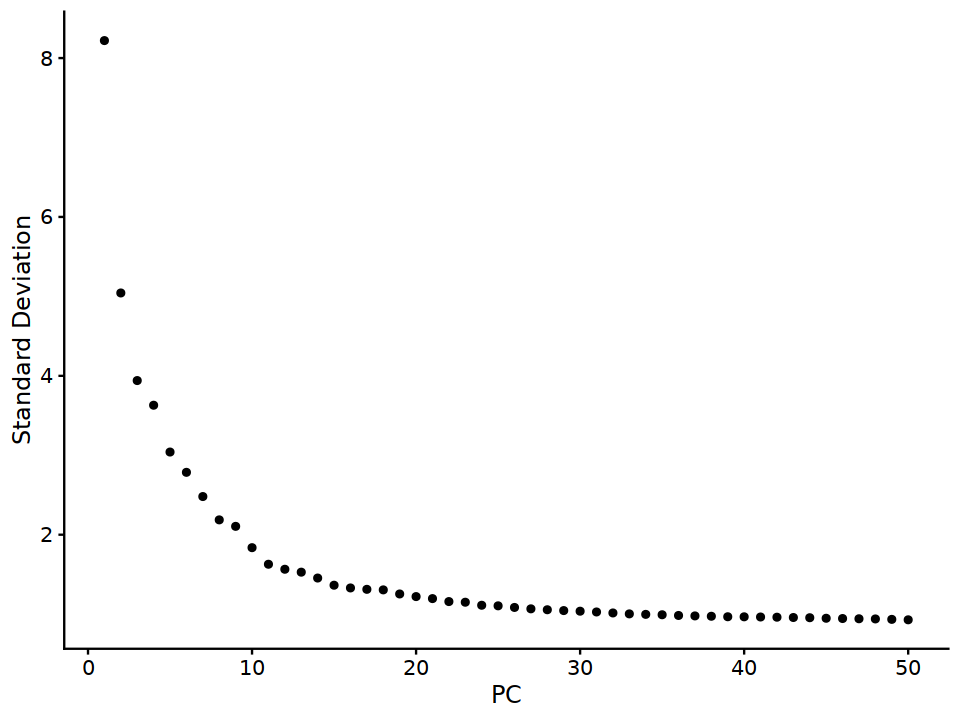

In [16]:
options(repr.plot.width = 8, repr.plot.height = 6)
ElbowPlot(seurat_obj, n=50)

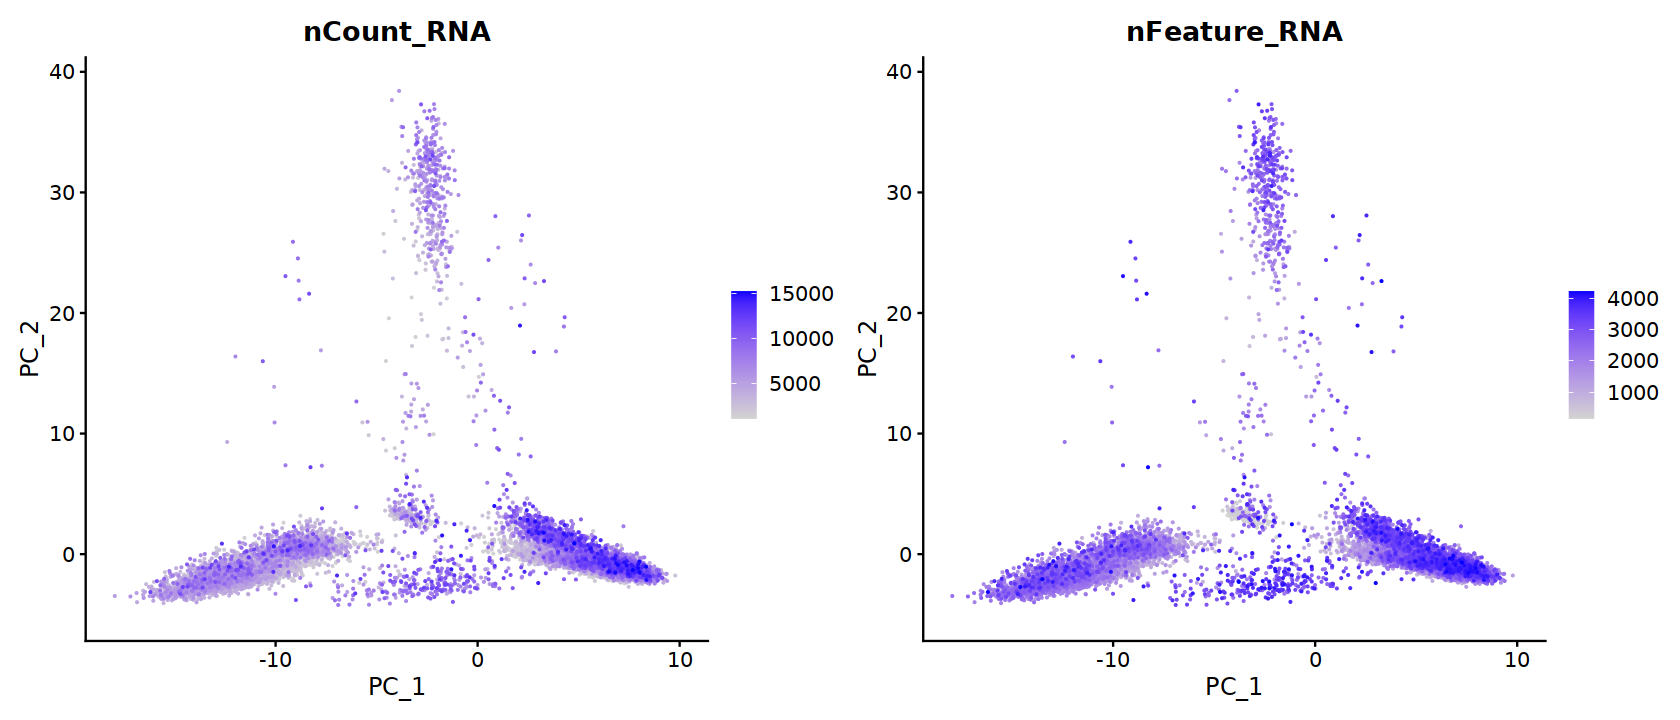

In [17]:
options(repr.plot.width = 14, repr.plot.height = 6)
FeaturePlot(object = seurat_obj, reduction = "pca",
        features = c("nCount_RNA","nFeature_RNA"), order=T)

In [18]:
comp=20

In [19]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:comp,
  reduction = "pca",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

17:17:50 UMAP embedding parameters a = 0.9922 b = 1.112

17:17:50 Read 15824 rows and found 20 numeric columns

17:17:50 Using Annoy for neighbor search, n_neighbors = 30

17:17:50 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:17:51 Writing NN index file to temp file /scratch_tmp/33937378/RtmpgHrG9V/file23ac5712d0056

17:17:51 Searching Annoy index using 1 thread, search_k = 3000

17:17:56 Annoy recall = 100%

17:17:57 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

17:17:58 Initializing from normalized Laplacian + noise (using irlba)

17:17:59 Commencing optimization for 200 epochs, with 672034 positive edges

17:18:17 Optimization finished



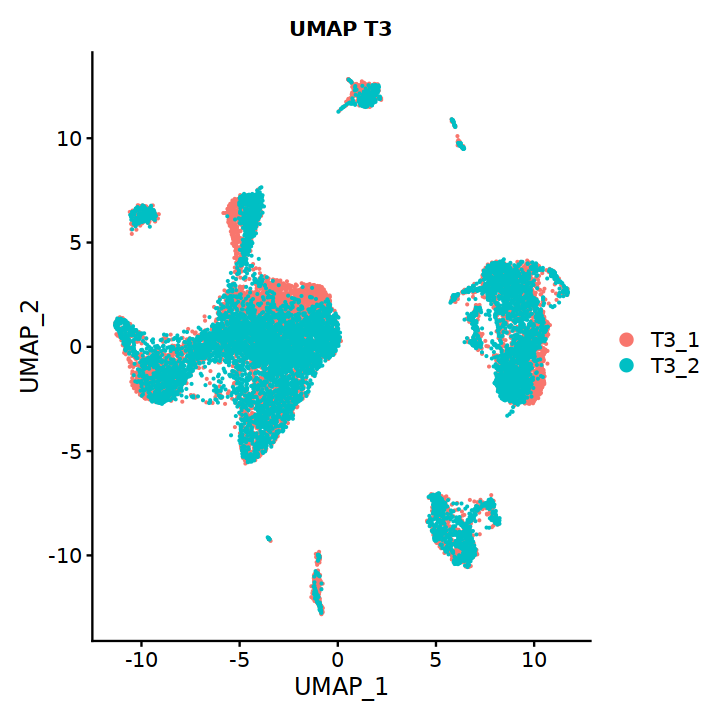

In [20]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle(glue('UMAP {timepoint}')) + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

Integrate with harmony

In [21]:
# make a copy of the PCA reduction
seurat_obj@reductions$pca_filt <- seurat_obj@reductions$pca

# Filter to the desired number of components according to elbow
seurat_obj@reductions$pca_filt@cell.embeddings <- seurat_obj@reductions$pca_filt@cell.embeddings[, c(1:comp)]
seurat_obj@reductions$pca_filt@feature.loadings <- seurat_obj@reductions$pca_filt@feature.loadings[, c(1:comp)]

In [22]:
seurat_obj <- RunHarmony(
  object = seurat_obj,
  reduction = "pca_filt",
  group.by.vars = "sample_id",
  assay.use = "RNA",
  project.dim = FALSE,
  reduction.save = "harmony"
)

Transposing data matrix

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony converged after 4 iterations



In [23]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:comp,
  reduction = "harmony",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

17:18:30 UMAP embedding parameters a = 0.9922 b = 1.112

17:18:30 Read 15824 rows and found 20 numeric columns

17:18:30 Using Annoy for neighbor search, n_neighbors = 30

17:18:30 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:18:32 Writing NN index file to temp file /scratch_tmp/33937378/RtmpgHrG9V/file23ac56b80cfbc

17:18:32 Searching Annoy index using 1 thread, search_k = 3000

17:18:37 Annoy recall = 100%

17:18:37 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

17:18:39 Initializing from normalized Laplacian + noise (using irlba)

17:18:39 Commencing optimization for 200 epochs, with 672660 positive edges

17:18:57 Optimization finished



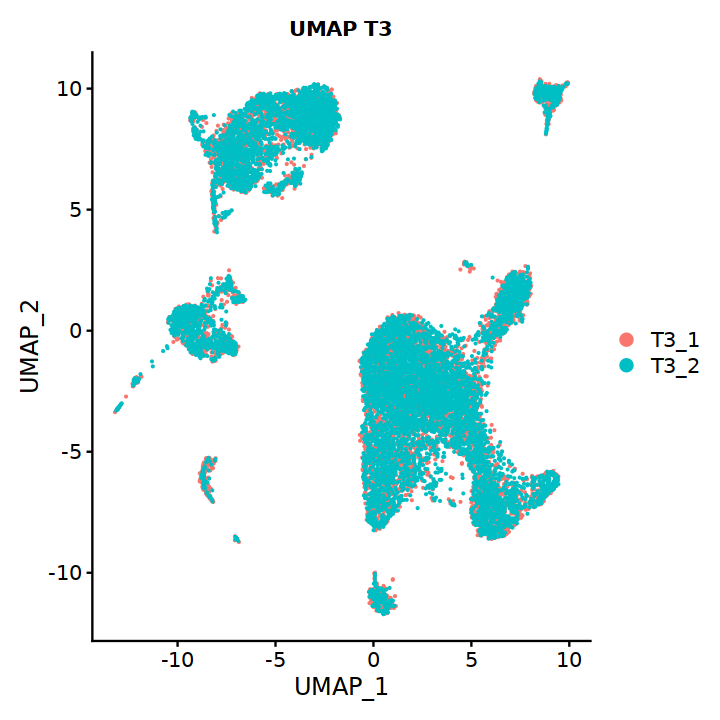

In [24]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle(glue('UMAP {timepoint}')) + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

## Remove doublets

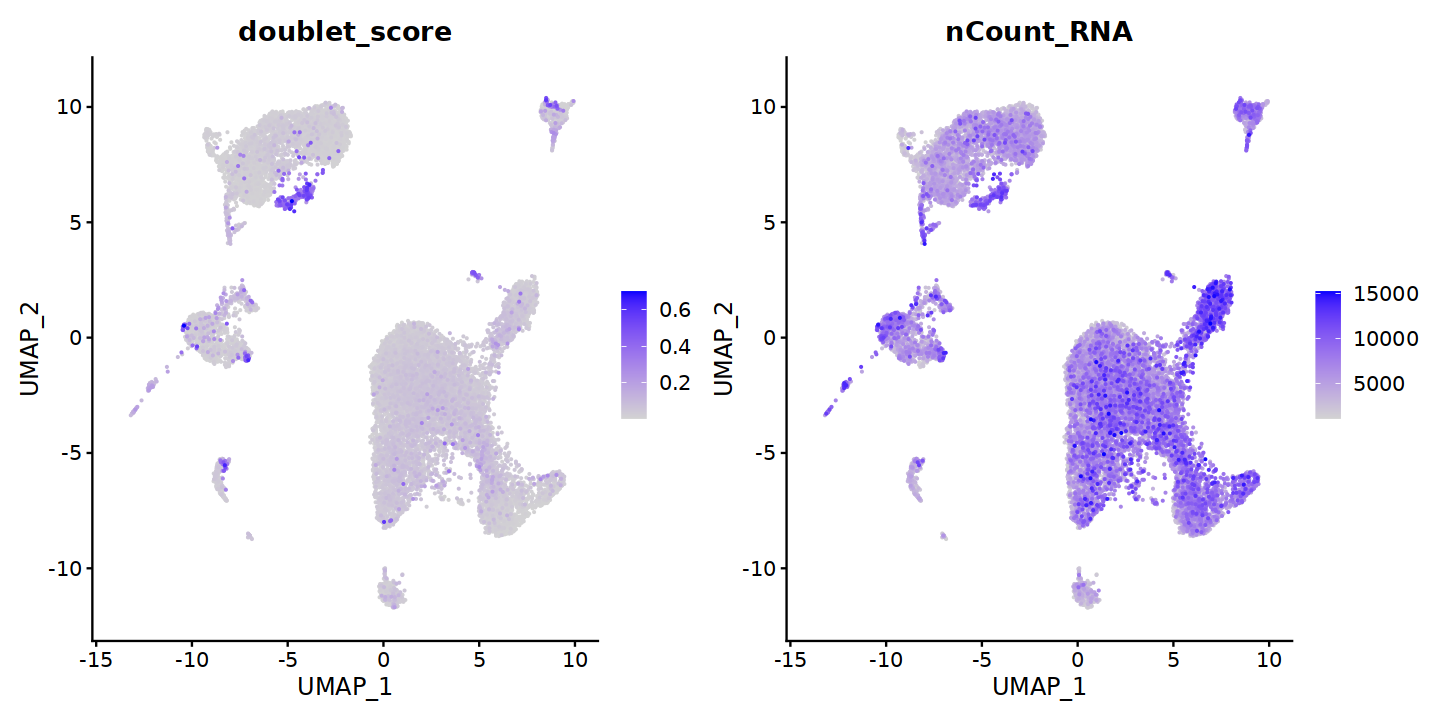

In [25]:
options(repr.plot.width = 12, repr.plot.height = 6, warn=-1,verbose = FALSE)
FeaturePlot(seurat_obj, reduction = "umap", 
            feature=c("doublet_score", "nCount_RNA"), order = TRUE)

In [26]:
head(seurat_obj@meta.data)

orig.ident   nCount_RNA nFeature_RNA sample_org
T3_1_AAACCTGAGACCTTTG-1 SCGRES_83_84  2299      1350         OS0028_1  
T3_1_AAACCTGAGAGGTACC-1 SCGRES_83_84 14148      4032         OS0028_1  
T3_1_AAACCTGAGGATGCGT-1 SCGRES_83_84  2287      1287         OS0028_1  
T3_1_AAACCTGAGTGAAGTT-1 SCGRES_83_84  7222      2540         OS0028_1  
T3_1_AAACCTGAGTGTCTCA-1 SCGRES_83_84  2268      1357         OS0028_1  
T3_1_AAACCTGCACCGAATT-1 SCGRES_83_84  4120      1978         OS0028_1  
                        timepoint replicate sample_id pct_mt   percent.ribo
T3_1_AAACCTGAGACCTTTG-1 T3        1         T3_1      3.436277 15.311005   
T3_1_AAACCTGAGAGGTACC-1 T3        1         T3_1      2.982754 14.143342   
T3_1_AAACCTGAGGATGCGT-1 T3        1         T3_1      3.585483 17.796240   
T3_1_AAACCTGAGTGAAGTT-1 T3        1         T3_1      3.752423 10.924952   
T3_1_AAACCTGAGTGTCTCA-1 T3        1         T3_1      4.144621  8.553792   
T3_1_AAACCTGCACCGAATT-1 T3        1         T3_1      3.543689 12.014563   
                        doublet_score doublet_pred S.Score      G2M.Score  
T3_1_AAACCTGAGACCTTTG-1 0.026785714   FALSE         0.028790028 -0.09297793
T3_1_AAACCTGAGAGGTACC-1 0.069155844   FALSE        -0.044001337 -0.07994225
T3_1_AAACCTGAGGATGCGT-1 0.381171824    TRUE        -0.001458462  0.01760473
T3_1_AAACCTGAGTGAAGTT-1 0.022921109   FALSE        -0.015208375 -0.03410542
T3_1_AAACCTGAGTGTCTCA-1 0.003668977   FALSE         0.080892888 -0.01012551
T3_1_AAACCTGCACCGAATT-1 0.051654560   FALSE         0.104274495  0.01899396
                        Phase old.ident   
T3_1_AAACCTGAGACCTTTG-1 S     SCGRES_83_84
T3_1_AAACCTGAGAGGTACC-1 G1    SCGRES_83_84
T3_1_AAACCTGAGGATGCGT-1 G2M   SCGRES_83_84
T3_1_AAACCTGAGTGAAGTT-1 G1    SCGRES_83_84
T3_1_AAACCTGAGTGTCTCA-1 S     SCGRES_83_84
T3_1_AAACCTGCACCGAATT-1 S     SCGRES_83_84

### First clustering to localize doublets

In [27]:
# Find the K-nearest neighbors
seurat_obj <- FindNeighbors(seurat_obj, reduction = "pca", dims = 1:30)
# Find clusters at different resolutions
clusters_df <- cluster_diff_resolutions(
  seurat_obj = seurat_obj,
  min_resolution = 0.1,
  max_resolution = 1.0,
  step = 0.1
)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15824
Number of edges: 575043

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9673
Number of communities: 13
Elapsed time: 2 seconds


1 singletons identified. 12 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15824
Number of edges: 575043

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9472
Number of communities: 14
Elapsed time: 2 seconds


1 singletons identified. 13 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15824
Number of edges: 575043

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9332
Number of communities: 14
Elapsed time: 2 seconds


1 singletons identified. 13 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15824
Number of edges: 575043

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9198
Number of communities: 17
Elapsed time: 2 seconds


1 singletons identified. 16 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15824
Number of edges: 575043

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9082
Number of communities: 19
Elapsed time: 2 seconds


1 singletons identified. 18 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15824
Number of edges: 575043

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8979
Number of communities: 19
Elapsed time: 2 seconds


1 singletons identified. 18 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15824
Number of edges: 575043

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8877
Number of communities: 19
Elapsed time: 2 seconds


1 singletons identified. 18 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15824
Number of edges: 575043

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8784
Number of communities: 19
Elapsed time: 2 seconds


1 singletons identified. 18 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15824
Number of edges: 575043

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8702
Number of communities: 21
Elapsed time: 2 seconds


1 singletons identified. 20 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15824
Number of edges: 575043

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8624
Number of communities: 20
Elapsed time: 2 seconds


1 singletons identified. 19 final clusters.



In [28]:
list_plots <- lapply(unique(clusters_df$resolution), function(x) {
  p <- add_reso_results(seurat_obj, clusters_df, resolution=x)
  umap <- DimPlot(p, reduction = "umap", 
                  group.by=glue::glue("seurat_clusters")) +
    labs(title=glue::glue("Resolution {x}"))
  return(umap)
})

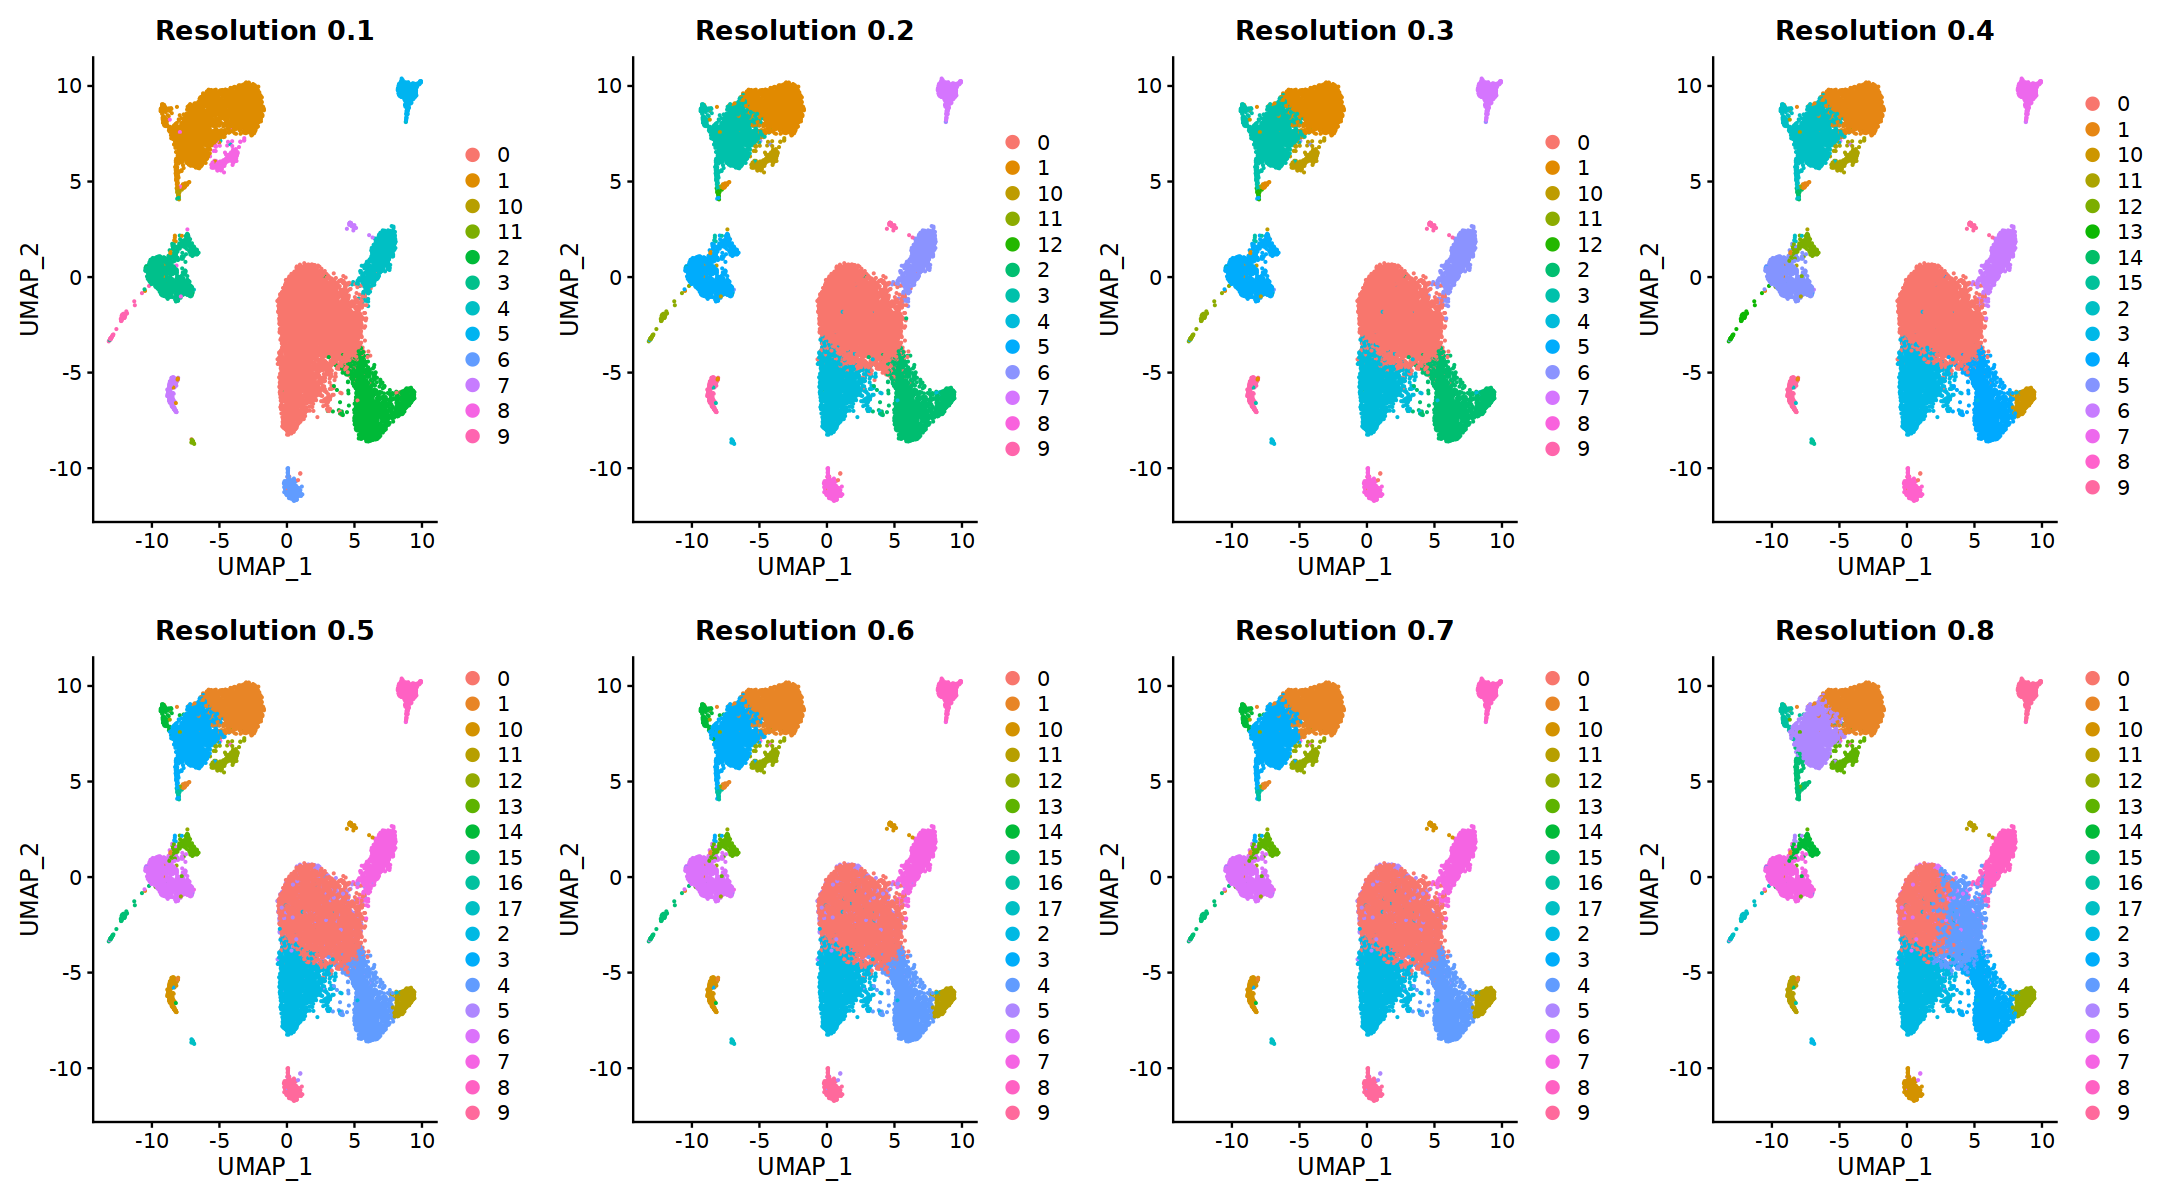

In [29]:
options(repr.plot.width = 18, repr.plot.height = 10, warn=-1,verbose = FALSE)
cp <- cowplot::plot_grid(plotlist = list_plots,
                   align = "hv",
                   axis = "trbl",
                   ncol=4,
                   nrow=2)
cp

In [30]:
reso = 0.1

In [31]:
seurat_obj <- FindClusters(seurat_obj, resolution = reso)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15824
Number of edges: 575043

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9673
Number of communities: 13
Elapsed time: 2 seconds


1 singletons identified. 12 final clusters.



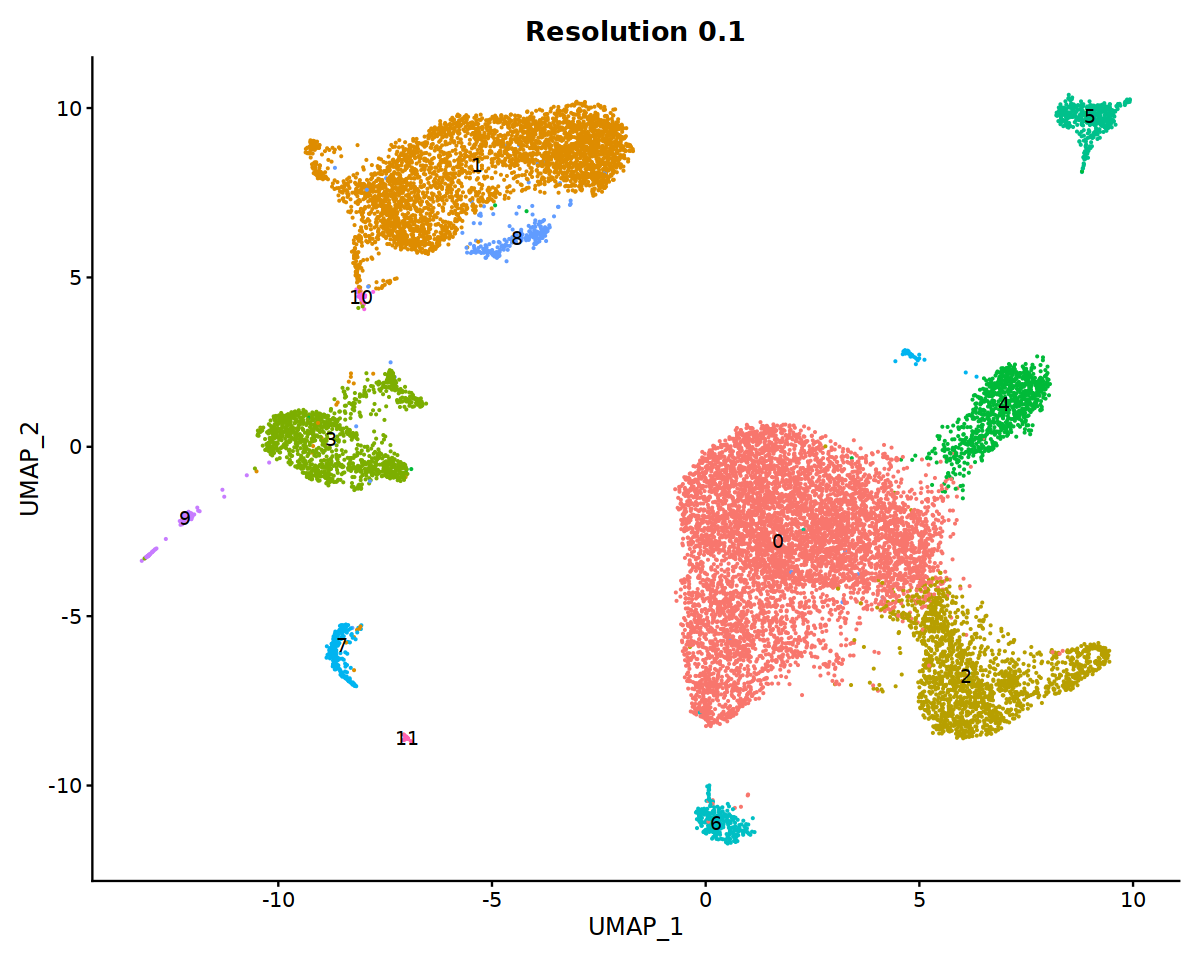

In [32]:
options(repr.plot.width = 10, repr.plot.height = 8, warn=-1,verbose = FALSE)
DimPlot(seurat_obj, reduction = "umap", label = T)+ NoLegend() +
  labs(title=glue("Resolution {reso}")) + theme(plot.title = element_text(hjust = 0.5))

### Obtain markers to corroborate doublets by gene expression

In [33]:
rna.markers <- FindAllMarkers(seurat_obj, min.pct = 0.1, logfc.threshold = 0.1, 
                              random.seed=0, max.cells.per.ident=1000,only.pos=TRUE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11



In [34]:
write_csv(rna.markers, here(glue("{clust}/{robj_dir}/3.2-first_clustering_{timepoint}.csv")))

In [35]:
markers <- c("PTPRC","nCount_RNA", "nFeature_RNA",
             "doublet_score",
             "CD3E", "CD3D","NCAM1","KLRD1","FCGR3A",
             "CD14", "CD68", 
             "S100A8", "SPP1", "CD163", "MSR1",
             "HBB")

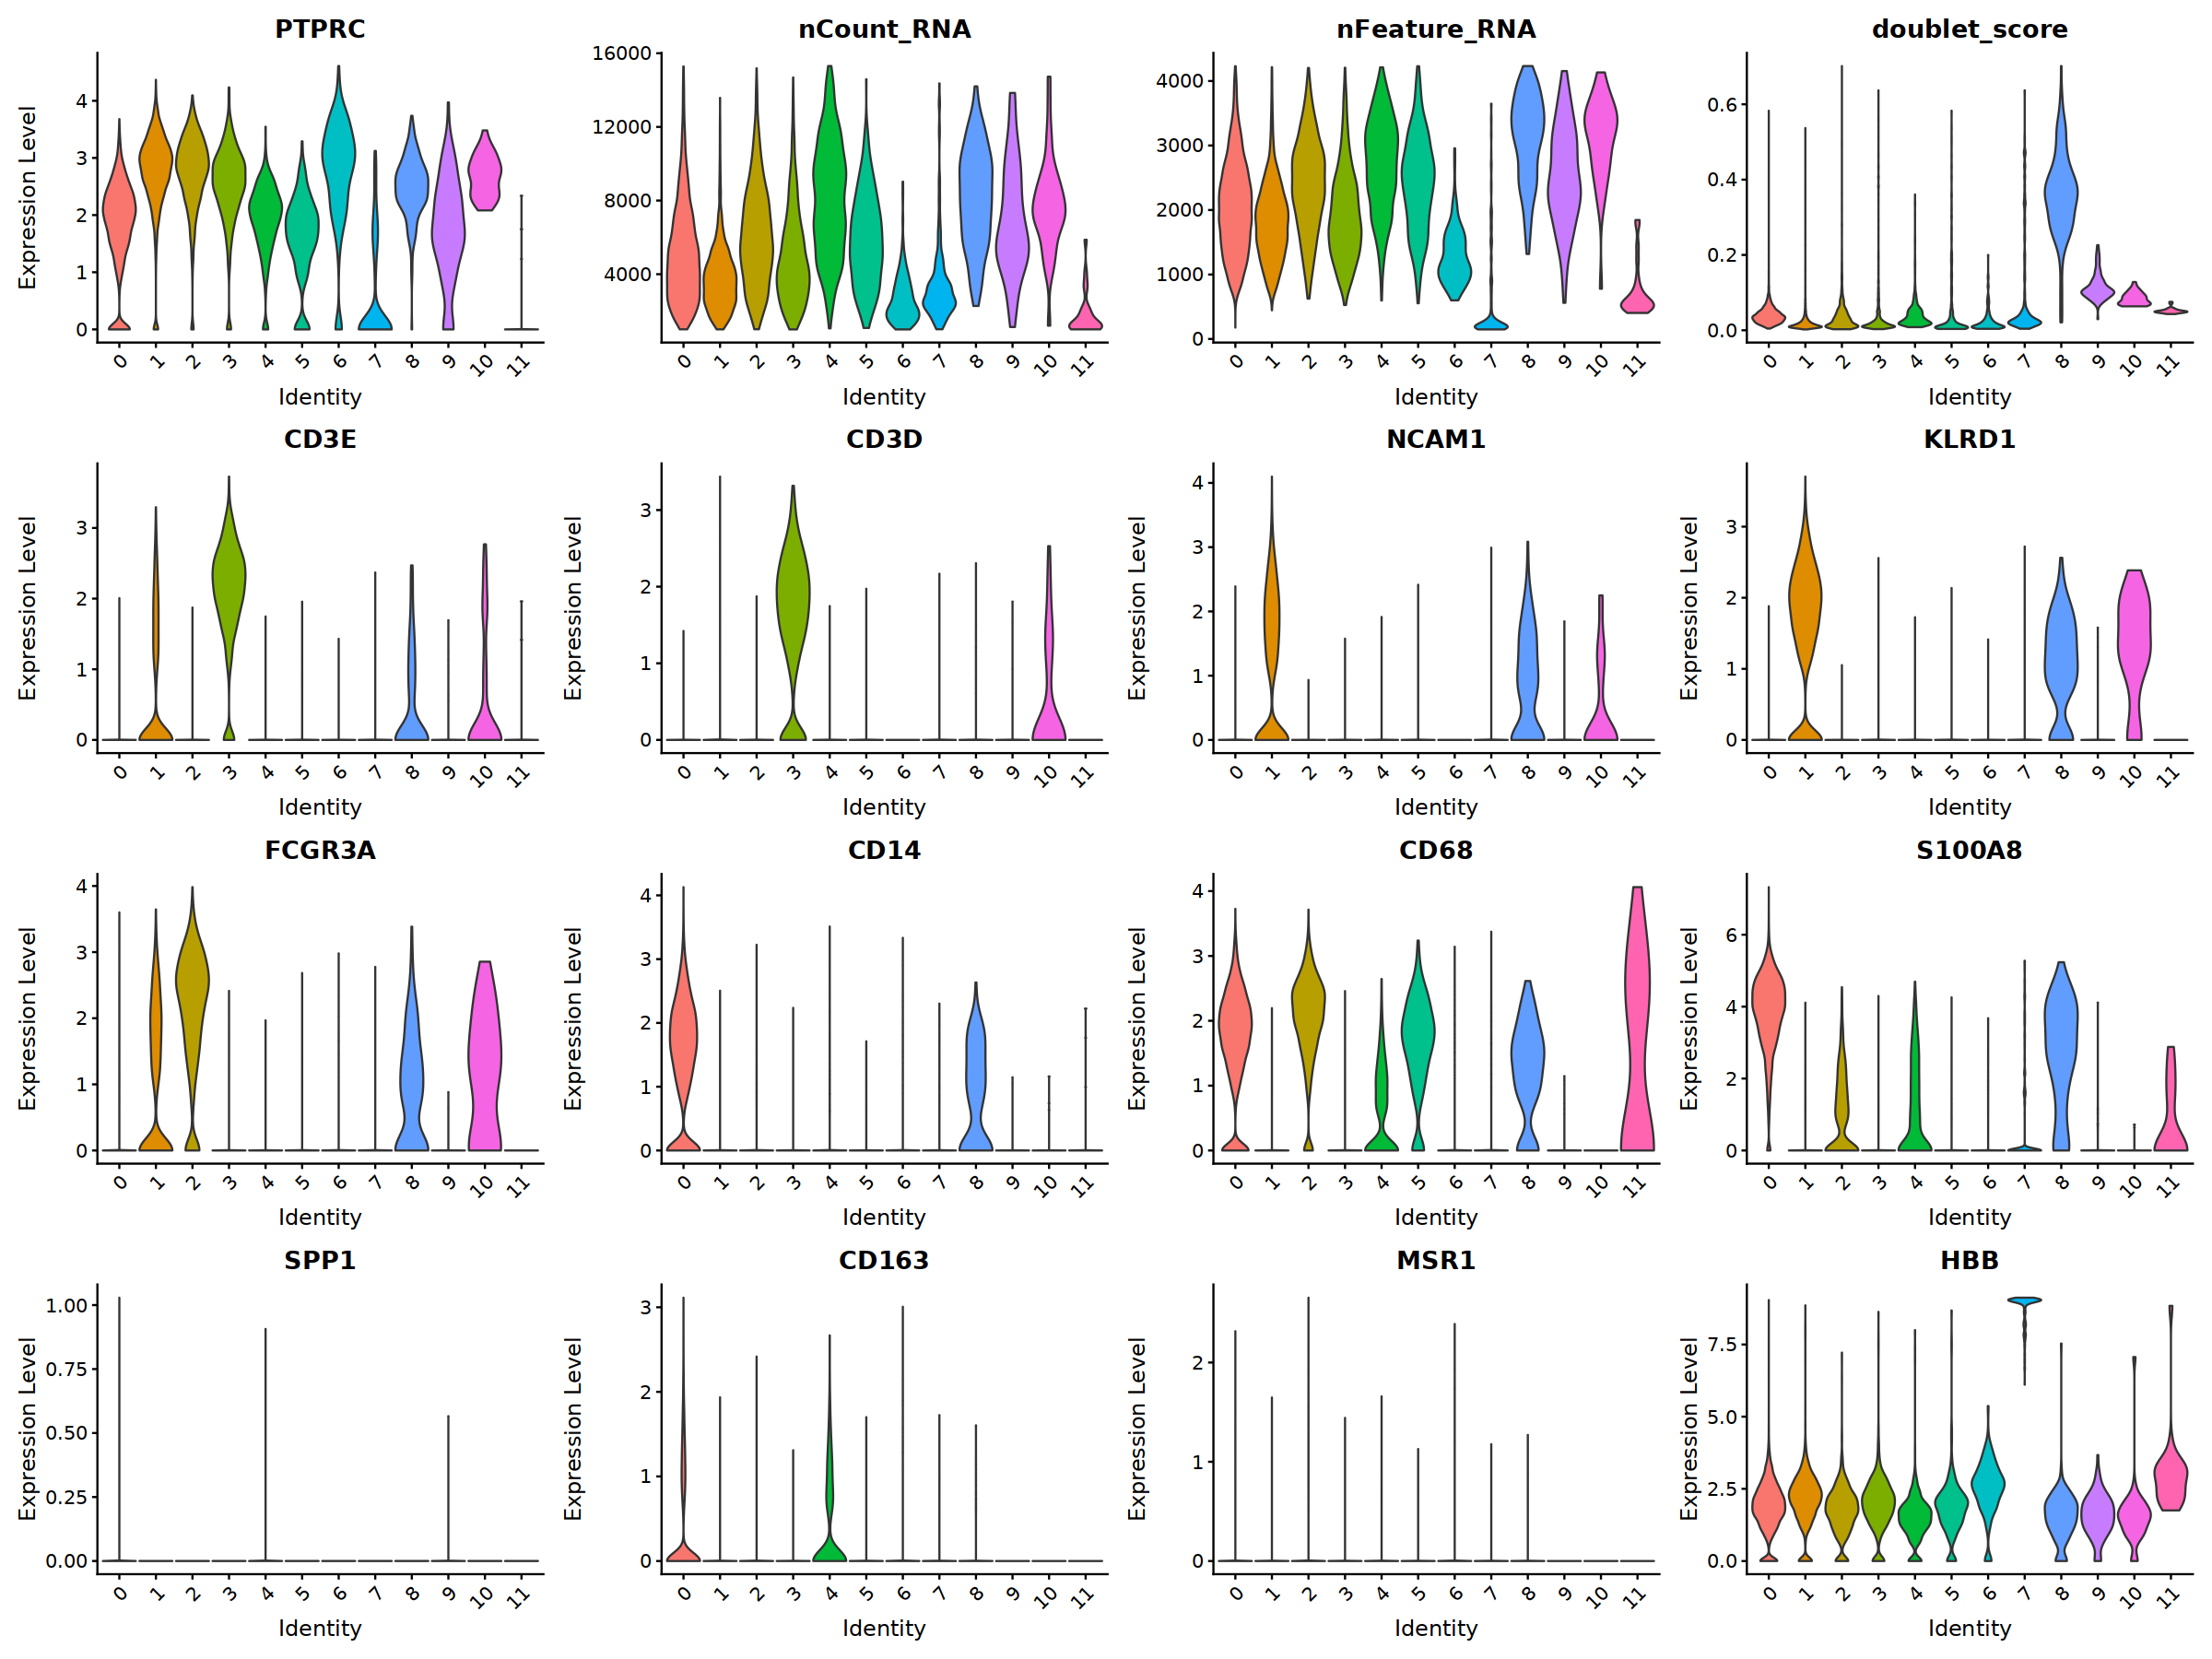

In [36]:
options(repr.plot.width = 20, repr.plot.height = 15, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj, feature=markers, ncol=4, pt.size = 0)

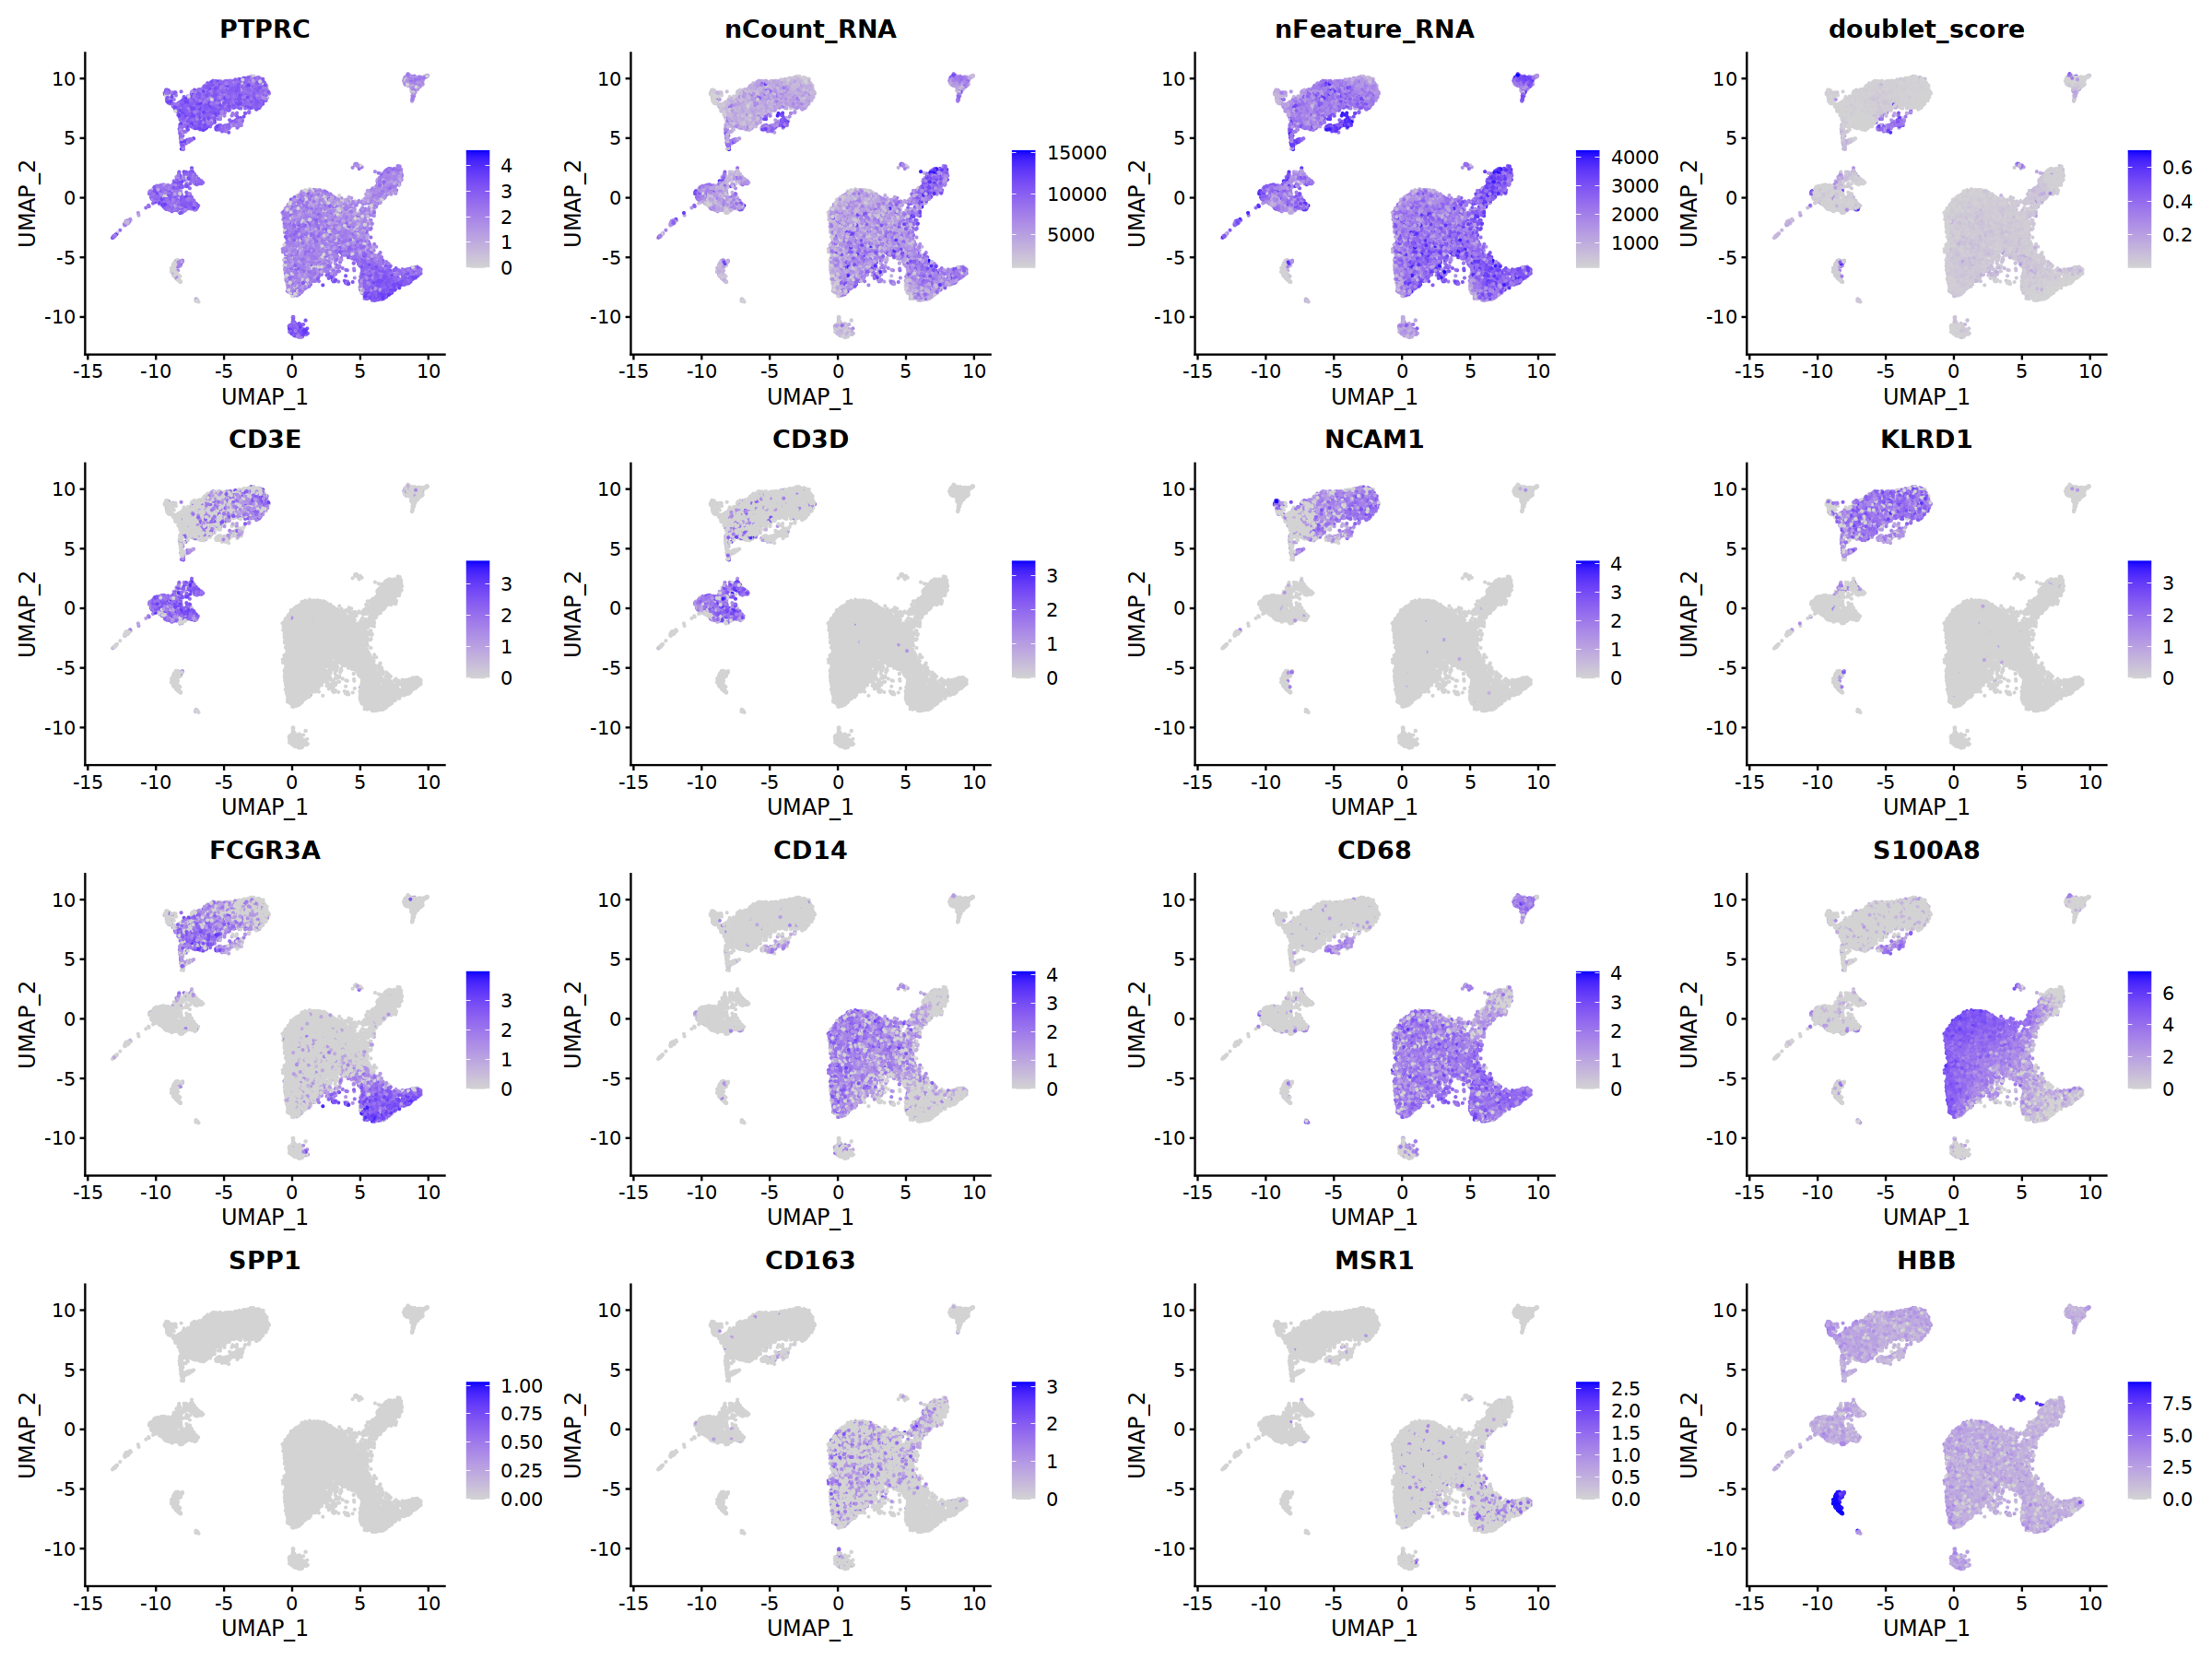

In [37]:
options(repr.plot.width = 20, repr.plot.height = 15, warn=-1,verbose = FALSE)
FeaturePlot(seurat_obj, ncol=4,
            feature=markers)

low quality cells

In [38]:
c <- 7
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=15)

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene    
HBB       1.398328e-144 8.928805   1.000 0.922 3.827084e-140 7       HBB     
HBD       5.129258e-218 6.148447   0.914 0.038 1.403827e-213 7       HBD     
HBA2      1.351134e-234 5.607806   1.000 0.063 3.697918e-230 7       HBA2    
ALAS2     2.210665e-252 5.606923   0.986 0.028 6.050368e-248 7       ALAS2   
HBA1      4.959057e-238 5.053886   1.000 0.052 1.357244e-233 7       HBA1    
CA1       4.568990e-221 5.021957   0.882 0.020 1.250487e-216 7       CA1     
AHSP      4.725708e-233 4.480260   0.914 0.016 1.293379e-228 7       AHSP    
SNCA      1.101580e-198 3.991955   0.943 0.091 3.014915e-194 7       SNCA    
SLC4A1    4.393986e-211 3.950771   0.850 0.014 1.202590e-206 7       SLC4A1  
SLC25A371 2.103572e-154 3.690065   0.939 0.245 5.757267e-150 7       SLC25A37
DCAF12    4.918108e-180 3.598627   0.893 0.103 1.346037e-175 7       DCAF12  
UBB1      4.910820e-130 3.462212   0.986 0.750 1.344042e-125 7       UBB     
SLC25A39  1.190667e-153 3.402156   0.911 0.196 3.258737e-149 7       SLC25A39
BCL2L1    2.015683e-170 3.286586   0.904 0.143 5.516722e-166 7       BCL2L1  
IFIT1B    1.048466e-160 3.232339   0.654 0.007 2.869547e-156 7       IFIT1B

doublets

In [39]:
c <- 8
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=15)

p_val        avg_log2FC pct.1 pct.2 p_val_adj    cluster gene     
GNLY1      2.743865e-47 0.7913906  0.963 0.263 7.509684e-43 8       GNLY     
CD2472     2.947878e-41 0.7037410  0.936 0.290 8.068048e-37 8       CD247    
IL2RB1     1.092275e-39 0.6821214  0.900 0.251 2.989447e-35 8       IL2RB    
NCALD2     2.034831e-37 0.6540360  0.699 0.179 5.569130e-33 8       NCALD    
CTSW1      1.245971e-36 0.6396542  0.950 0.283 3.410098e-32 8       CTSW     
PRKCH2     8.890157e-32 0.6324265  0.900 0.347 2.433147e-27 8       PRKCH    
NKG71      3.496889e-33 0.6238973  0.968 0.340 9.570636e-29 8       NKG7     
CCL51      3.371896e-29 0.6087841  0.863 0.339 9.228543e-25 8       CCL5     
PRF11      3.255861e-41 0.5961179  0.877 0.238 8.910965e-37 8       PRF1     
NCAM11     2.340711e-35 0.5874853  0.626 0.155 6.406291e-31 8       NCAM1    
SYNE11     1.263431e-33 0.5806656  0.877 0.319 3.457884e-29 8       SYNE1    
SLC38A13   1.290822e-24 0.5488599  0.822 0.333 3.532852e-20 8       SLC38A1  
LINC002991 1.791371e-34 0.5484754  0.498 0.115 4.902803e-30 8       LINC00299
KLRD11     1.093772e-38 0.5470760  0.799 0.202 2.993544e-34 8       KLRD1    
CST71      1.111965e-35 0.5457044  0.858 0.243 3.043338e-31 8       CST7

### Remove cells

In [40]:
seurat_obj <- subset(seurat_obj, idents=c(7,8), invert=TRUE)

In [41]:
print(table(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) == 0))
  
keep_genes <- data.frame(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) != 0)
colnames(keep_genes) <- "logical"
keep_genes <- subset(keep_genes, logical==TRUE)
seurat_obj[['RNA']]@counts <- seurat_obj[['RNA']]@counts[rownames(keep_genes), ]
seurat_obj[['RNA']]@data <- seurat_obj[['RNA']]@data[rownames(keep_genes), ]
seurat_obj


FALSE  TRUE 
27284    85 


An object of class Seurat 
27284 features across 15325 samples within 1 assay 
Active assay: RNA (27284 features, 0 variable features)
 4 dimensional reductions calculated: pca, umap, pca_filt, harmony

## Re-do embedding and clustering

In [42]:
seurat_obj <- NormalizeData(
  seurat_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)

In [43]:
sce <- as.SingleCellExperiment(seurat_obj)
sce

class: SingleCellExperiment 
dim: 27284 15325 
metadata(0):
assays(2): counts logcounts
rownames(27284): AL627309.1 AL627309.3 ... UTY TMSB4Y
rowData names(0):
colnames(15325): T3_1_AAACCTGAGACCTTTG-1 T3_1_AAACCTGAGAGGTACC-1 ...
  T3_2_TTTGTCATCCTGCCAT-1 T3_2_TTTGTCATCTTAGCCC-1
colData names(18): orig.ident nCount_RNA ... seurat_clusters ident
reducedDimNames(4): PCA UMAP PCA_FILT HARMONY
mainExpName: RNA
altExpNames(0):

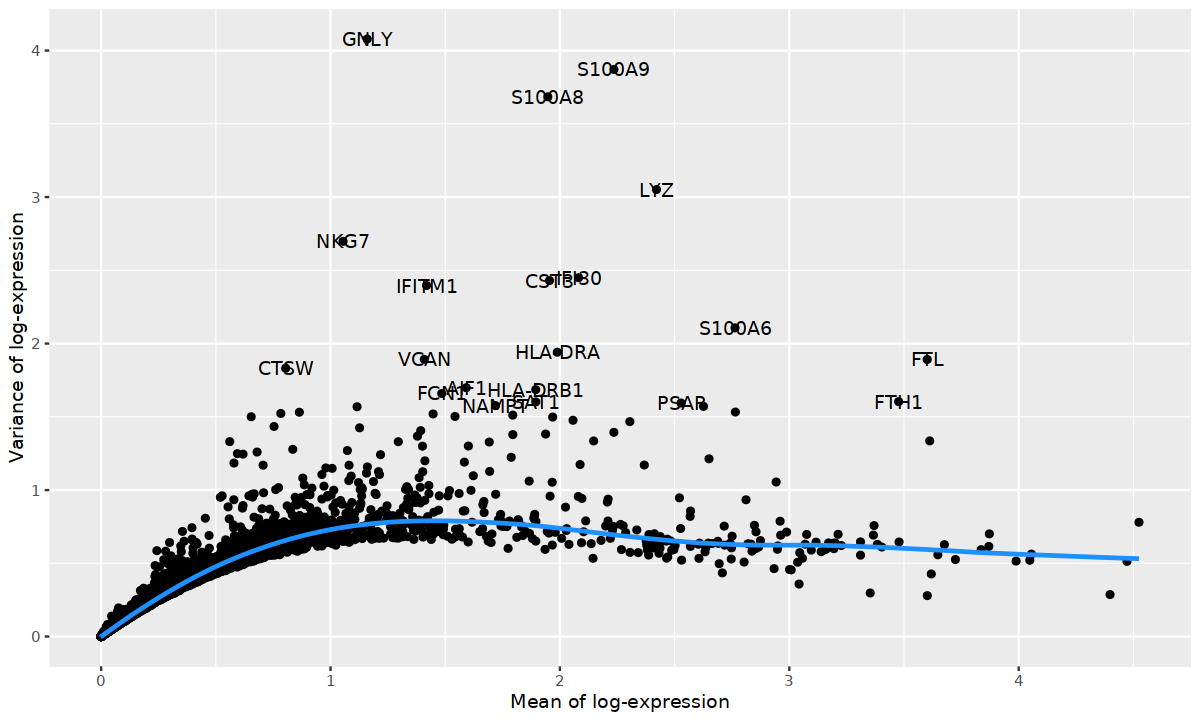

In [44]:
options(repr.plot.width = 10, repr.plot.height = 6, warn=-1,verbose = FALSE)
gene_var <- modelGeneVar(sce)

tops <- gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)

gene_var %>% 
  as.data.frame() %>% 
  ggplot(aes(mean, total)) +
  geom_point() +
  geom_line(aes(y = tech), colour = "dodgerblue", size = 1) +
  labs(x = "Mean of log-expression", y = "Variance of log-expression")+
  geom_text(data=tops, aes(mean,total,label=rownames(tops)))

In [45]:
hvgs <- getTopHVGs(gene_var,fdr.threshold = 0.05)
length(hvgs)

[1] 1156

In [46]:
hvgs <- hvgs[!grepl("^TR[ABDG][VJC]", hvgs)]
length(hvgs)

[1] 1063

In [47]:
seurat_obj <- seurat_obj %>%
  ScaleData(features=hvgs) %>% 
  RunPCA(features=hvgs)

Centering and scaling data matrix

PC_ 1 
Positive:  IFI30, LYZ, AIF1, FCN1, S100A6, FTL, S100A9, LST1, CTSS, PSAP 
	   NAMPT, CST3, SPI1, S100A11, CYBB, CDKN1A, PLXDC2, HLA-DRA, S100A8, SERPINA1 
	   HLA-DRB1, VIM, CD68, VCAN, SAT1, FTH1, MNDA, GABARAP, RBM47, MAFB 
Negative:  CD7, CD247, CTSW, NKG7, GNLY, IFITM1, IL2RB, SKAP1, IL2RG, PRF1 
	   GZMA, CST7, SLC38A1, PRKCH, ZAP70, CD69, CD96, KLRB1, KLRK1, TENT5C 
	   KLRD1, IL32, RNF125, SAMD3, GZMM, SYNE1, ETS1, EVL, MCTP2, KLRF1 
PC_ 2 
Positive:  IFITM3, NEAT1, ANXA1, S100A10, ARHGAP26, NFKBIA, S100A4, JUNB, SLC2A3, TSPO 
	   S100A9, IFITM2, CCL5, S100A8, FCN1, IFITM1, NKG7, NR4A2, ATP2B1, PRF1 
	   GNLY, GZMA, LYZ, MAFB, CST7, NAMPT, IL2RB, VCAN, IFI30, SERPINA1 
Negative:  JCHAIN, LILRA4, SERPINF1, CLEC4C, NIBAN3, RHEX, IGKC, ITM2C, DERL3, MZB1 
	   PTPRS, SPIB, LINC01374, LINC01478, TCF4, CUX2, COBLL1, DNASE1L3, AC023590.1, TLR9 
	   SMPD3, RGS7, PLD4, LINC00996, AC007381.1, TPM2, IGHM, MAP1A, COL24A1, MYBL2 
PC_ 3 
Positive:  CD

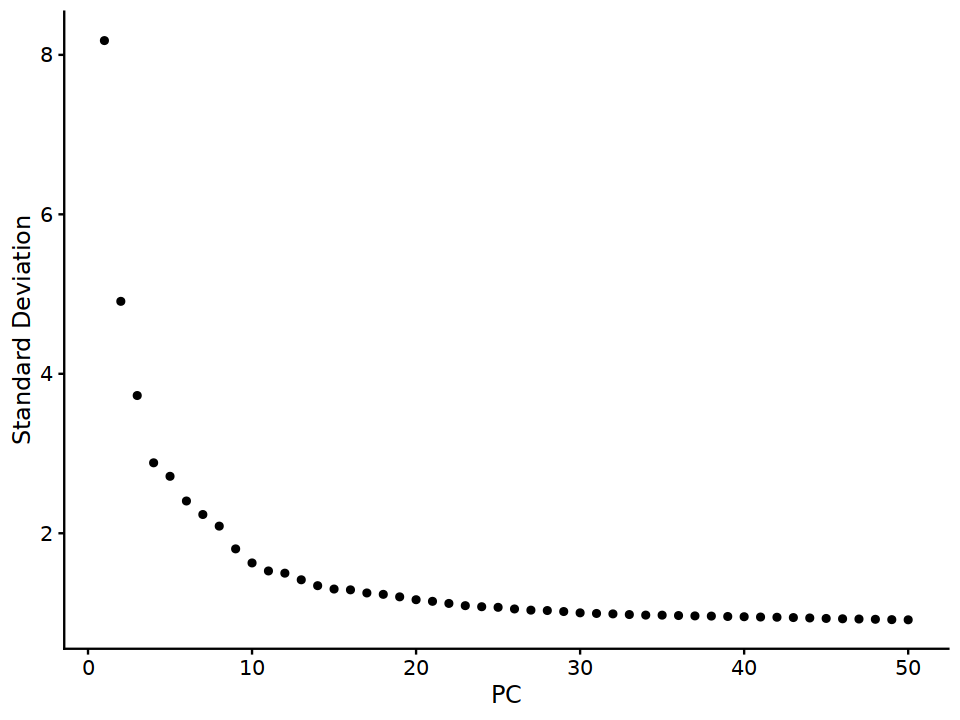

In [48]:
options(repr.plot.width = 8, repr.plot.height = 6)
ElbowPlot(seurat_obj, n=50)

In [49]:
comp=20

In [50]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:comp,
  reduction = "pca",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

17:22:32 UMAP embedding parameters a = 0.9922 b = 1.112

17:22:32 Read 15325 rows and found 20 numeric columns

17:22:32 Using Annoy for neighbor search, n_neighbors = 30

17:22:32 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:22:33 Writing NN index file to temp file /scratch_tmp/33937378/RtmpgHrG9V/file23ac55a911678

17:22:33 Searching Annoy index using 1 thread, search_k = 3000

17:22:38 Annoy recall = 100%

17:22:39 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

17:22:40 Initializing from normalized Laplacian + noise (using irlba)

17:22:41 Commencing optimization for 200 epochs, with 651364 positive edges

17:22:58 Optimization finished



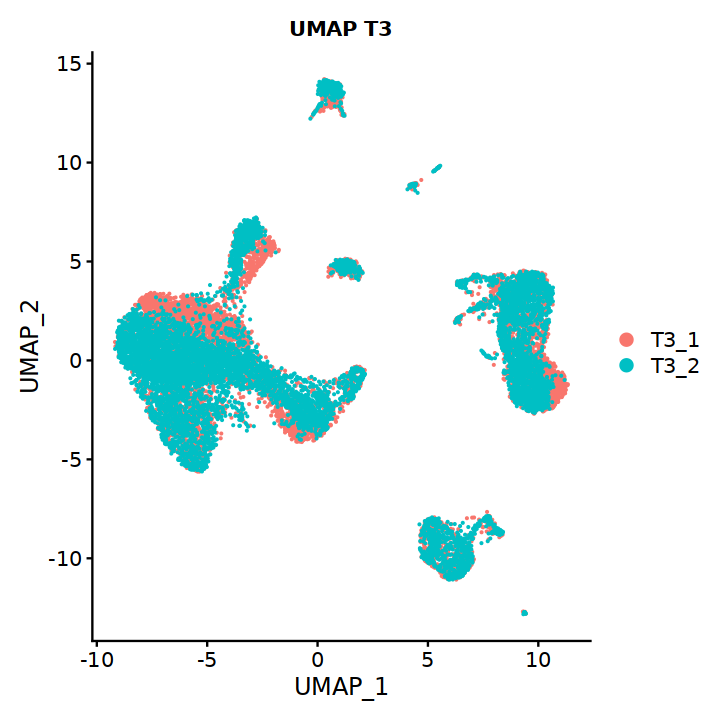

In [51]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle(glue('UMAP {timepoint}')) + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

In [52]:
# make a copy of the PCA reduction
seurat_obj@reductions$pca_filt <- seurat_obj@reductions$pca

# Filter to the desired number of components according to elbow
seurat_obj@reductions$pca_filt@cell.embeddings <- seurat_obj@reductions$pca_filt@cell.embeddings[, c(1:comp)]
seurat_obj@reductions$pca_filt@feature.loadings <- seurat_obj@reductions$pca_filt@feature.loadings[, c(1:comp)]

seurat_obj <- RunHarmony(
  object = seurat_obj,
  reduction = "pca_filt",
  group.by.vars = "sample_id",
  assay.use = "RNA",
  project.dim = FALSE,
  reduction.save = "harmony"
)

Transposing data matrix

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony converged after 5 iterations



In [53]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:comp,
  reduction = "harmony",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

17:23:13 UMAP embedding parameters a = 0.9922 b = 1.112

17:23:13 Read 15325 rows and found 20 numeric columns

17:23:13 Using Annoy for neighbor search, n_neighbors = 30

17:23:13 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:23:15 Writing NN index file to temp file /scratch_tmp/33937378/RtmpgHrG9V/file23ac57409f52e

17:23:15 Searching Annoy index using 1 thread, search_k = 3000

17:23:19 Annoy recall = 100%

17:23:20 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

17:23:21 Initializing from normalized Laplacian + noise (using irlba)

17:23:22 Commencing optimization for 200 epochs, with 652814 positive edges

17:23:39 Optimization finished



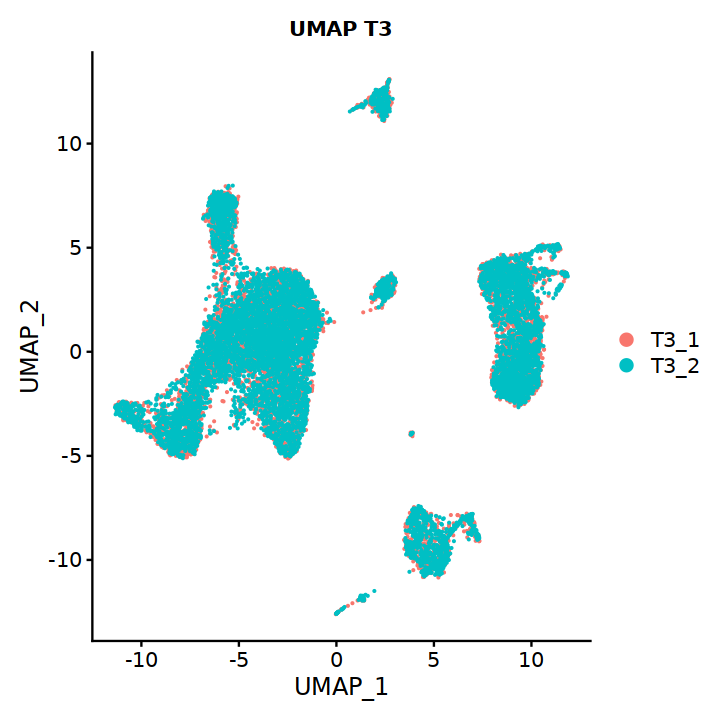

In [54]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle(glue('UMAP {timepoint}')) + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

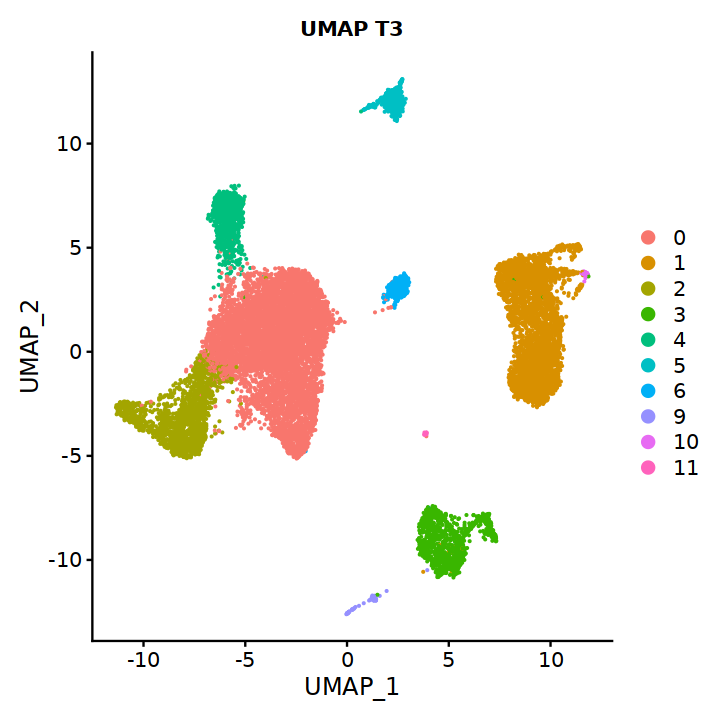

In [55]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  pt.size = 0.1
) + ggtitle(glue('UMAP {timepoint}')) + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

### Clustering 

In [56]:
seurat_obj <- FindNeighbors(seurat_obj, reduction = "harmony", dims = 1:comp)

Computing nearest neighbor graph

Computing SNN



In [57]:
reso = 0.2

In [58]:
seurat_obj <- FindClusters(seurat_obj, resolution = reso)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15325
Number of edges: 535414

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9454
Number of communities: 12
Elapsed time: 2 seconds


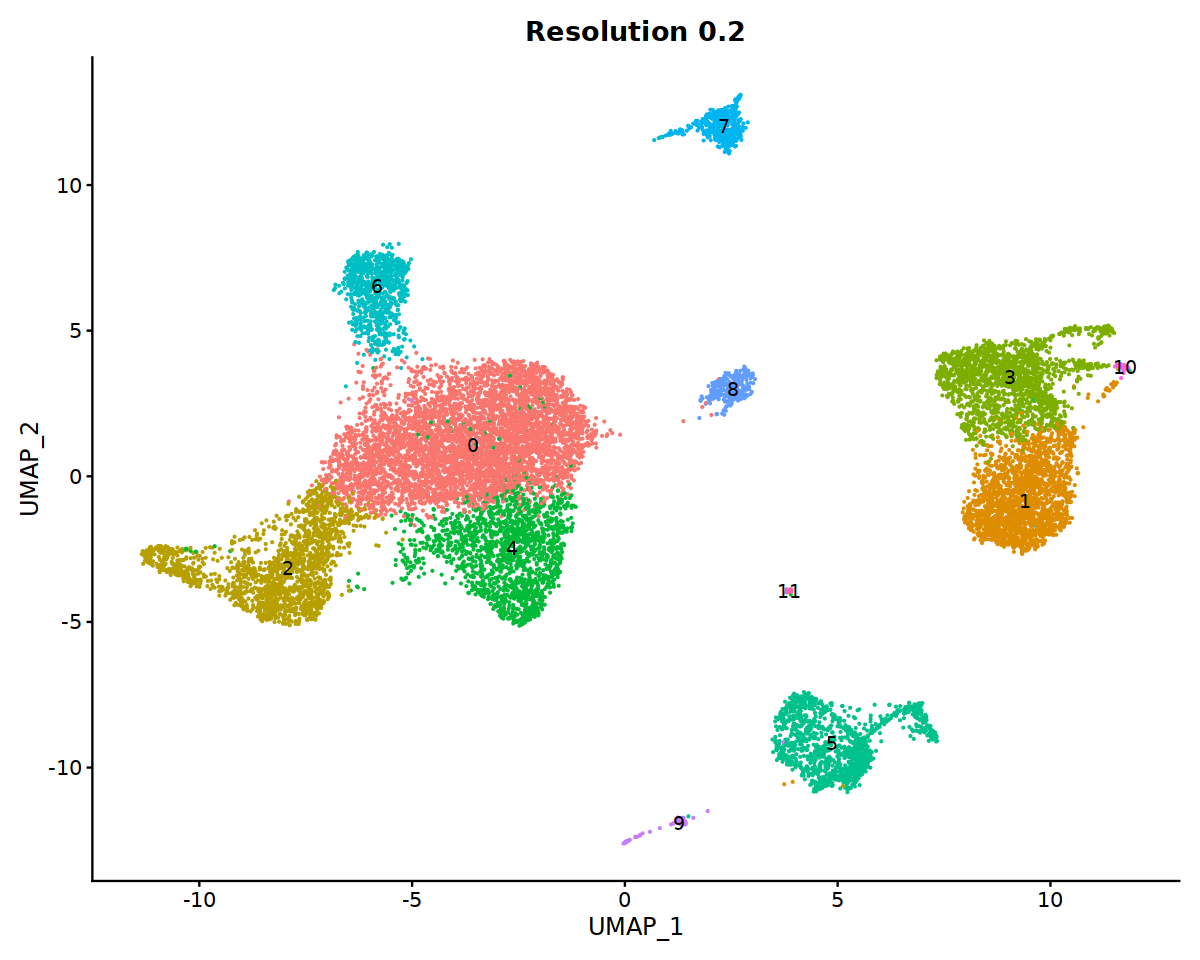

In [59]:
options(repr.plot.width = 10, repr.plot.height = 8, warn=-1,verbose = FALSE)
DimPlot(seurat_obj, reduction = "umap", label = T)+ NoLegend() +
  labs(title=glue("Resolution {reso}")) + theme(plot.title = element_text(hjust = 0.5))

### Compute markers

In [60]:
rna.markers <- FindAllMarkers(seurat_obj, min.pct = 0.1, only.pos = T,
                              logfc.threshold = 0.1, random.seed=0, 
                              max.cells.per.ident=1000)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11



# Save

In [61]:
saveRDS(seurat_obj, here::here(glue::glue("{clust}/{robj_dir}/3.2-clustering_{timepoint}.rds")))

In [62]:
write_csv(rna.markers, here(glue("{clust}/{robj_dir}/3.2-clustering_{timepoint}.csv")))

# Session Info

In [63]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scran_1.22.1                scater_1.22.0              
 [3] scuttle_1.4.0               SingleCellExperiment_1.16.0
 [5] SummarizedExperiment_1.24.0 Biobase_2.54.0             
 [7] GenomicRanges_1.46.1        GenomeInfoDb_1.30.1        
 [9] IRanges_